In [12]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import seed
from random import randrange
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from numpy import random
import seaborn as sns
random.seed(1)
np.random.seed(1)
#Given a data point expressed by the numerical features of our dataset (which describe a given breast mass), classify that data point into one of two classes (malignant or benign)
bcw=pd.read_csv('data.csv')

# data cleaning : do not chose ID column
df=bcw.loc[:,"diagnosis":"fractal_dimension_worst"]
# data normalization 
df_normalized=(df.iloc[:,1:31]-df.iloc[:,1:31].mean())/(df.iloc[:,1:31].std())
df_normalized.insert(30,"diagnosis",bcw.loc[:,"diagnosis"])
#print(df_normalized.head())

y=df_normalized.iloc[:,-1]
le = LabelEncoder() # label transformation into 1 or 0
y = le.fit_transform(y) # Malignant transfer into 1 and Benign tranfer into 0
x=df_normalized.iloc[:,0:df_normalized.shape[1]-1]
x=x.to_numpy()
df_numpy=np.concatenate((x, y.reshape(1, -1).T), axis=1)
#print(df_numpy)
def get_xy(data):
    y=data.iloc[:,-1]
    le=LabelEncoder()
    y=le.fit_transform(y)
    x=data.iloc[:,0:data.shape[1]-1]
    x=x.to_numpy()
    return x,y
    

# Data Reduction by PCA
By PCA method, I can find the first 10 components can explain 95% variance. We can reduce this dataset from 30 to 10 dimensions. 

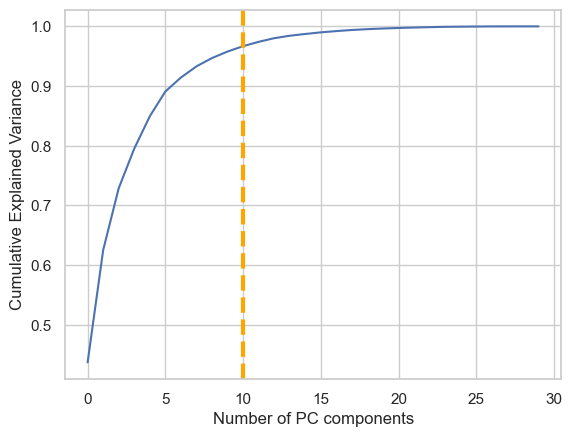

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.436764,0.436764
1,0.625006,0.188243
2,0.728709,0.103702
3,0.795143,0.066435
4,0.849359,0.054215
5,0.890853,0.041494
6,0.914234,0.023381
7,0.932970,0.018737
8,0.946927,0.013956
9,0.957794,0.010868


In [13]:
random.seed(1)
np.random.seed(1)
# normalized data which is normal and center. 
df_pca=df_normalized.copy(deep=False)
df_pca['is_train'] = np.random.uniform(0, 1, len(df))<= .50
df_train, df_test = df_pca[df_pca['is_train']==True], df_pca[df_pca['is_train']==False]

# data reduction by PCA
features=df_pca.columns[0:30]
x=df_train[features]
pca = PCA(n_components = 30)
X_pca = pca.fit_transform(x)
X_pca = pd.DataFrame(X_pca)
#np.cumsum(pca.explained_variance_ratio_)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('Number of PC components') 
plt.ylabel('Cumulative Explained Variance') 
plt.axvline(linewidth=3, color='orange', linestyle = '--', x=10, ymin=0, ymax=1) 
display(plt.show())

# When pc=15, those PCs can explain 98% variance
evr = pca.explained_variance_ratio_ 
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame() 
pca_df['Cumulative Variance Ratio'] = cvr 
pca_df['Explained Variance Ratio'] = evr 
display(pca_df.head(15)) 

# find pca x when pc=10 and construst train and test PCA dataset
le=LabelEncoder()
train_y=le.fit_transform(df_train.iloc[:,-2])
test_y=le.fit_transform(df_test.iloc[:,-2])
pca_10 = PCA(n_components=10) 
pca_10.fit(df_train[features])
X_train_pca10 = pca_10.transform(df_train[features]) 
train_pca10=np.concatenate((X_train_pca10, train_y.reshape(1, -1).T), axis=1)
X_test_pca10 = pca_10.transform(df_test[features]) 
test_pca10=np.concatenate((X_test_pca10, test_y.reshape(1, -1).T), axis=1)

# combine pca train and test set and transfer it into pd.dataframe
data_pca=np.vstack((train_pca10,test_pca10))
data_pca=pd.DataFrame(data_pca)

In [16]:
random.seed(1)
np.random.seed(1)
def entropy(df_label):
    # count how many counts for 0 and 1 by using bincount
    counts=np.bincount(df_label)
    prob=counts/len(df_label)
    entropy=-np.sum([p*np.log2(p) for p in prob if p > 0])
    return entropy

def information_gain(parent, left_label, right_label):
    left_entropy=entropy(left_label)
    right_entropy=entropy(right_label)
    parent_entropy=entropy(parent)
    info_gain=parent_entropy-(left_entropy*np.sum(left_label)/len(left_label)+right_entropy*np.sum(right_label)/len(right_label))
    return info_gain

# X is the dataset with only feature and y is outcome lable of X dataset
def find_best_split(dataset,n_features):
    # to get input x and outcome y and transfer y to be intger in order to for using bincount funtion.  
    X=dataset[:,:-1]
    y=dataset[:,-1].astype(int)
    #y=le.fit_transform(y)
    best_feature = None
    best_threshold = None
    best_info_gain = float("inf")
    best_split = {}
    best_info_gain = -1
    # go through each features and each thresholds value in dataset to find best split.   
    for feature_id in range(n_features): #feature_id_set
        feature_values = X[:, feature_id]
        thresholds = np.unique(feature_values)
        for threshold in thresholds:
            parent = np.concatenate((X, y.reshape(1, -1).T), axis=1)
            # go through each row in parent to get left child and right child
            left_child = np.array([row for row in parent if row[feature_id] <= threshold])
            right_child = np.array([row for row in parent if row[feature_id] > threshold])
            left_indices = np.where(feature_values <= threshold)[0]
            right_indices = np.where(feature_values > threshold)[0]
            # to make sure left child and right child are not empty sets
            if len(left_child) >0 and len(right_child) > 0:
                left_labels = y[left_indices]
                right_labels = y[right_indices]
                info_gain = information_gain(y, left_labels, right_labels)
                if info_gain > best_info_gain:
                    best_split = {
                            'feature_id': feature_id,
                            'best_threshold': threshold,
                            'left_child': left_child,
                            'right_child': right_child,
                            'best_info_gain': info_gain
                    }
                    best_info_gain=info_gain
    return best_split

def split(node, max_depth, min_size, n_features,depth):
    left = node['left_child']
    right = node ['right_child']
    left=list(left)
    right=list(right)
    del(node['left_child'],node['right_child'])
    # check whether there is a no split or not
    if not left or not right:
        total=left+right
        node['left'] = node['right'] = max([row[-1] for row in total],key=[row[-1] for row in total].count)
        return
    # check whether it is max depth in the tree or not
    if depth >= max_depth:
        node['left'] = max([row[-1] for row in left],key=[row[-1] for row in left].count)
        node['right'] = max([row[-1] for row in right],key=[row[-1] for row in right].count)
        return
    # go through left child
    if len(left) <= min_size:
        node['left'] = max([row[-1] for row in left],key=[row[-1] for row in left].count)
    else:
        new_left=np.array(left)
        node['left'] = find_best_split(new_left,n_features)
        split(node['left'], max_depth, min_size,n_features, depth+1)
    # go through right child
    if len(right) <= min_size:
        node['right'] = max([row[-1] for row in right],key=[row[-1] for row in right].count)
    else:
        new_right=np.array(right)
        node['right'] = find_best_split(new_right,n_features)
        split(node['right'], max_depth, min_size,n_features, depth+1) 


# build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = find_best_split(train,n_features)
    split(root, max_depth, min_size,n_features,1)
    return root

def predict(trees, row):
    pred=[]
    for tree in trees:
        node=tree
        while isinstance(node,dict):
            if row[node["feature_id"]]<node["best_threshold"]:
                node=node["left"]
            else:
                node=node["right"]
        pred.append(node)
    return max(set(pred),key=pred.count),pred



# in here train and test should be modified as a numpy array or matrix
def random_forest(train,test,max_depth, min_size, n_features,sample_frac,n_trees):
    trees_result=list()
    train=pd.DataFrame(train)
    test=pd.DataFrame(test)
    test=test.to_numpy()
    # go through each tree and save the result in trees result list
    for i in range(n_trees):
        sample=train.sample(frac=sample_frac,replace=True)
        sample=sample.to_numpy()
        tree=build_tree(sample,max_depth,min_size,n_features)
        trees_result.append(tree)
    pred=[]
    each_tree_decision=[]
    for row in test:
        result=predict(trees_result,row)
        pred.append(result[0])
        each_tree_decision.append(result[1])
        
    return pred,each_tree_decision

def cv_computation(k,data,max_depth, min_size, n_features,sample_frac,n_trees):
    kfold = KFold(n_splits=k,  shuffle=True,  random_state=1)
    Precision_result=np.empty(shape=(k))
    Recall_result=np.empty(shape=(k))
    F1_result=np.empty(shape=(k))
    Accuracy_result=np.empty(shape=(k))
    confusion_matrix_list=np.empty(shape=(k,2,2))
    for i, (train_id, test_id) in enumerate(kfold.split(data)):
        train_set=data.loc[train_id,:]
        train_x,train_y=get_xy(train_set)
        train_numpy=np.concatenate((train_x, train_y.reshape(1, -1).T), axis=1)
        
        test_set=data.loc[test_id,:]
        test_x,test_y=get_xy(test_set)
        test_numpy=np.concatenate((test_x, test_y.reshape(1, -1).T), axis=1)
        # find pred by random forest 
        pred=random_forest(train_numpy,test_numpy,max_depth, min_size, n_features,sample_frac,n_trees)[0]
        #print(pred)
        y_true=list(test_y)
        y_pred=pred
        confusion_mat=confusion_matrix(y_true,y_pred)
        #print(type(confusion_mat))
        confusion_matrix_list[i]=confusion_mat
        # Precision
        Precision=confusion_mat[0,0]/confusion_mat.sum(axis=1)[0]
        Precision_result[i]=Precision
        #print("Precision is",Precision)
        # Recall
        #print(confusion_matrix.sum(axis=0)[0])
        Recall=confusion_mat[0,0]/confusion_mat.sum(axis=0)[0]
        Recall_result[i]=Recall
        #print("Recall is",Recall)
        # F1 score, F1=1 is best, F1=0 is worst
        F1=(2*Precision*Recall)/(Precision+Recall)
        F1_result[i]=F1
        # Accuracy
        Acc=(confusion_mat[0,0]+confusion_mat[1,1])/np.sum(confusion_mat)
        Accuracy_result[i]=Acc
        
    avg_Precision=np.mean(Precision_result)
    avg_Recall=np.mean(Recall_result)
    avg_F1=np.mean(F1_result)
    avg_Acc=np.mean(Accuracy_result)
    return avg_Precision,avg_Recall,avg_F1,avg_Acc,Precision_result,Recall_result,F1_result,Accuracy_result,confusion_matrix_list
        


# Hyperparameter Tuning in Random Forest
In this model, I need to tun 4 variables which are number of trees(n_trees), the large number of split for each trees, the minumum size of leaf(min_size)  and number of features (n_features). Cross validation is 3 folds (k=3) and the proportion of sample we used in training is 50%(sample_frac=0.5) are fixed. I will not discuss those in tuning. We can find the best average accuracy in 3-fold cv is 0.9455 and its parameter are: max_depth=2, min_size=5, n_features=20 and n_trees=5.

Apparently, I can find the max_depth, n_features and n_trees larger which is better.Since it has higher accuacy and lower variance from error bar plot below. 

P.S. Those parameters may not be a good choice, since I only try 3*3*3*3=81 ways of tuning, but it take a very long running time to see the result for my computer. 

In [52]:
random.seed(1)
np.random.seed(1)

max_depth_set=[2,3,4]
min_size_set=[5,10,15]
n_features_set=[10,15,20]
n_trees_set=[5,10,20]
avg_acc=np.empty(shape=(3,3,3,3))
# Tuning the hyperparameter 
for i in range(len(max_depth_set)):
    for j in range(len(min_size_set)):
        for m in range(len(n_features_set)):
            for n in range(len(n_trees_set)):
                avg_acc[i,j,m,n]=cv_computation(k=3,data=df_normalized,
                                                max_depth=max_depth_set[i],
                                                min_size=min_size_set[j],
                                                n_features=n_features_set[m],
                                                sample_frac=0.5,
                                                n_trees=n_trees_set[n])[3]

In [59]:
print("The best accuracy location is",np.where(avg_acc==np.max(avg_acc)))
print("The best accuracy is",avg_acc[0,0,2,0])

The best accuracy location is (array([0], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([0], dtype=int64))
The best accuracy is 0.9068040471549242


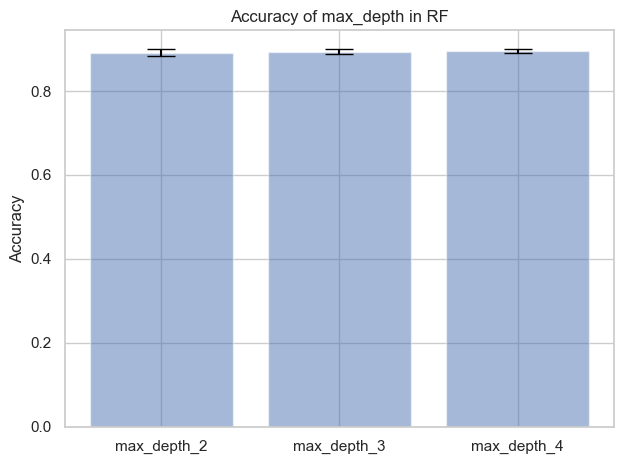

In [55]:
x=["max_depth_2","max_depth_3","max_depth_4"]
max_depth_2=np.mean(avg_acc[0,:,:,:])
max_depth_2_sd=np.std(avg_acc[0,:,:,:])
max_depth_3=np.mean(avg_acc[1,:,:,:])
max_depth_3_sd=np.std(avg_acc[1,:,:,:])
max_depth_4=np.mean(avg_acc[2,:,:,:])
max_depth_4_sd=np.std(avg_acc[2,:,:,:])


CTEs = [max_depth_2,max_depth_3,max_depth_4]
error = [max_depth_2_sd,max_depth_3_sd,max_depth_4_sd]
x_pos = np.arange(len(x))
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.set_title('Accuracy of max_depth in RF')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

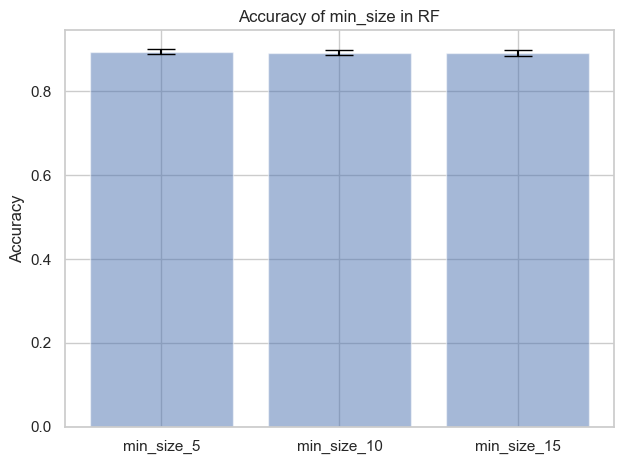

In [56]:
x=["min_size_5","min_size_10","min_size_15"]
max_depth_2=np.mean(avg_acc[:,0,:,:])
max_depth_2_sd=np.std(avg_acc[:,0,:,:])
max_depth_3=np.mean(avg_acc[:,1,:,:])
max_depth_3_sd=np.std(avg_acc[:,1,:,:])
max_depth_4=np.mean(avg_acc[:,2,:,:])
max_depth_4_sd=np.std(avg_acc[:,2,:,:])


CTEs = [max_depth_2,max_depth_3,max_depth_4]
error = [max_depth_2_sd,max_depth_3_sd,max_depth_4_sd]
x_pos = np.arange(len(x))
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.set_title('Accuracy of min_size in RF')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

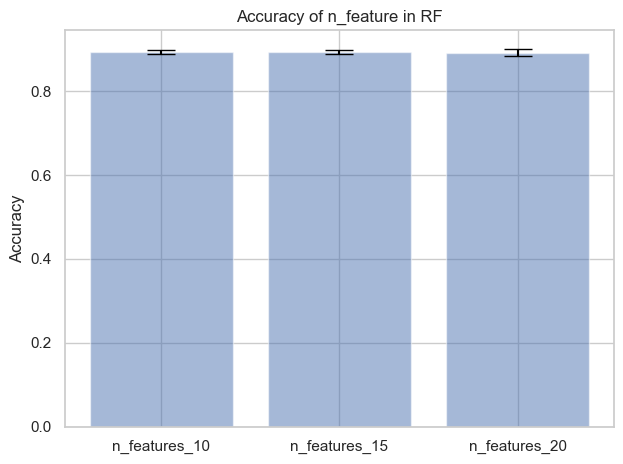

In [57]:
x=["n_features_10","n_features_15","n_features_20"]
max_depth_2=np.mean(avg_acc[:,:,0,:])
max_depth_2_sd=np.std(avg_acc[:,:,0,:])
max_depth_3=np.mean(avg_acc[:,:,1,:])
max_depth_3_sd=np.std(avg_acc[:,:,1,:])
max_depth_4=np.mean(avg_acc[:,:,2,:])
max_depth_4_sd=np.std(avg_acc[:,:,2,:])


CTEs = [max_depth_2,max_depth_3,max_depth_4]
error = [max_depth_2_sd,max_depth_3_sd,max_depth_4_sd]
x_pos = np.arange(len(x))
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.set_title('Accuracy of n_feature in RF')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

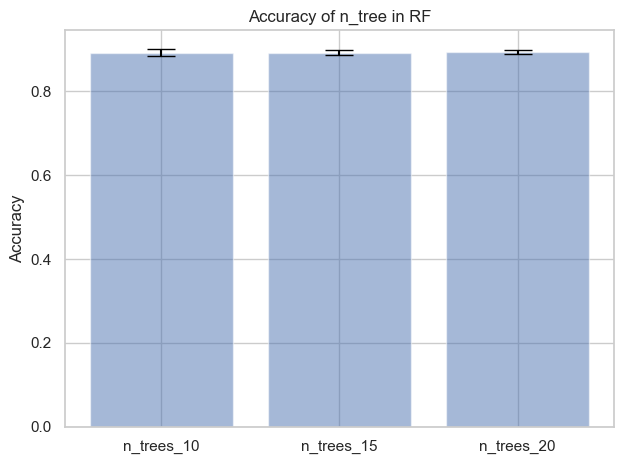

In [58]:
x=["n_trees_10","n_trees_15","n_trees_20"]
max_depth_2=np.mean(avg_acc[:,:,:,0])
max_depth_2_sd=np.std(avg_acc[:,:,:,0])
max_depth_3=np.mean(avg_acc[:,:,:,1])
max_depth_3_sd=np.std(avg_acc[:,:,:,1])
max_depth_4=np.mean(avg_acc[:,:,:,2])
max_depth_4_sd=np.std(avg_acc[:,:,:,2])


CTEs = [max_depth_2,max_depth_3,max_depth_4]
error = [max_depth_2_sd,max_depth_3_sd,max_depth_4_sd]
x_pos = np.arange(len(x))
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.set_title('Accuracy of n_tree in RF')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

# Random Forest in reality data
In cancer data, we can find the precision is 0.971,recall is 0.867, F1 is 0.916 and accuracy is 0.889 when we only have 5 trees 20 features and training sample porpotion is 0.5. 

We also want to see if data reduction by PCA, how does the result change? Remember, We has reduce the dimension from 30 to 10 which has around 95% in the variation. I have create a pca data called data_pca and run it in our random forest model. Since it only has 10 dimension of feature, we cannot chose 20 for n_features. Hence I want to use n_feature=10 instead to compare result with data reduction and without data dareduction in random forest model. 


In [20]:
random.seed(1)
np.random.seed(1)
k=3
result_data=cv_computation(k=k,data=df_normalized,max_depth=4,min_size=15,n_features=20,sample_frac=0.5,n_trees=5)
result_data
print("The average of precision in",k,"fold cv is",result_data[0])
print("The average of recall in",k,"fold cv is",result_data[1])
print("The average of F1 in",k,"fold cv is",result_data[2])
print("The average of accuracy in",k,"fold cv is",result_data[3])

The average of precision in 3 fold cv is 0.971869662081008
The average of recall in 3 fold cv is 0.8677125629261994
The average of F1 in 3 fold cv is 0.9166204295688111
The average of accuracy in 3 fold cv is 0.8892509050403787


Comparing the two dataset results, I can find the PCA does not have a better result than the orginal dataset. PCA has a smaller precision which is 97% and original dataset has 98% precision. It has good precision to predict a result who is benigm, but there is a very bad recall which only 77%. which means if we predict 100 patients are benign, only 77 patients are really benign and 23 patient are maligant but we mark them are benign. When we find PCA's F1, which is 0.86 smaller than 0.92. 

Hence, PCA is not well. I think one of the reason is that, when we use PCA to do data reduction, some infomation is lost and it will reduce the model's interpretation. 

In [21]:
random.seed(1)
np.random.seed(1)
k=3
result_data=cv_computation(k=k,data=df_normalized,max_depth=4,min_size=15,n_features=10,sample_frac=0.5,n_trees=5)
result_data
print("The average of precision in",k,"fold cv is",result_data[0])
print("The average of recall in",k,"fold cv is",result_data[1])
print("The average of F1 in",k,"fold cv is",result_data[2])
print("The average of accuracy in",k,"fold cv is",result_data[3])

The average of precision in 3 fold cv is 0.986052086997582
The average of recall in 3 fold cv is 0.8650846332558912
The average of F1 in 3 fold cv is 0.9214775277687385
The average of accuracy in 3 fold cv is 0.8945047804696928


In [22]:
random.seed(1)
np.random.seed(1)
k=3
result_pca=cv_computation(k=k,data=data_pca,max_depth=4,min_size=15,n_features=10,sample_frac=0.5,n_trees=5)
result_pca
print("The average of precision in",k,"fold cv is",result_pca[0])
print("The average of recall in",k,"fold cv is",result_pca[1])
print("The average of F1 in",k,"fold cv is",result_pca[2])
print("The average of accuracy in",k,"fold cv is",result_pca[3])

The average of precision in 3 fold cv is 0.9780268072950999
The average of recall in 3 fold cv is 0.7743933482149298
The average of F1 in 3 fold cv is 0.8635757411913131
The average of accuracy in 3 fold cv is 0.806720504966119


# Decision Tree in Correctness Data
(1)
In Implementation correctness we have 17 datapoints and 2 features. 
In one decision tree method, the tree select feature one firstly amd then select feature two secondly. The reason we choose the order like that because in feature has a larger infomation gain which will be choosed firstly. 
(2)
The feature split value is chose which is 8.5 and the second feature split value is 7.405. Those values are chosen because when we split this thresthold value, we will get the larger infomation gain. 

This is the reason we create find_best_split function to find split value and feature which has the largest infomation gain. 

In [23]:
random.seed(1)
np.random.seed(1)
# implementation correctness
correct_data=pd.read_csv('implementation_correctness_dataset.csv')
build_tree(correct_data.to_numpy(), max_depth=2, min_size=1, n_features=2)

{'feature_id': 0,
 'best_threshold': 8.5,
 'best_info_gain': -0.15445724182297282,
 'left': {'feature_id': 0,
  'best_threshold': 7.405,
  'best_info_gain': -0.170101453739689,
  'left': 1.0,
  'right': 1.0},
 'right': 1.0}

# Random Forest in Correctness Data
clarify: By LabelEncoder(),label transformation into 1 or 0, 1 represent class 2 and 0 represent class 1
(1)
In the random forest method, basical it is very simliar as the decision tree. When we create a tree, we will use decision tree to create a tree. In here I use n_trees=10 which means I create 10 trees and run buil_tree 10 times and split the data 10 times and then random forest will collect each trees final result to make decision for prediction. In ths example below, I have 10 trees all same result which are 0 (class 1). Finally, random forest predict it as class 1. 
(2)
In 20 trees, most of predictions are class 1 when we input [4,4]. Only 4 predictions are class 2. It is reasonable result for the split. Because when tree find the best feature and split from this dataset, feature 1 has many more than feature 2. When we create a threthold value and make a split. Feature 1 has a larger region than feature 2. [4,4] is easily to drop in feature 1 area. 


In [33]:
# part 1
random.seed(1)
np.random.seed(1)
train=correct_data
train_x,train_y=get_xy(train)
train_numpy=np.concatenate((train_x, train_y.reshape(1, -1).T), axis=1)
test=[[4,4,2]] # I random give a label for this point, but it will not affect our prediction, we only need [4,4] for prediction
test=pd.DataFrame(test,columns=["feature 1","feature 2","result"])
test_x,test_y=get_xy(test)
test_numpy=np.concatenate((test_x, test_y.reshape(1, -1).T), axis=1)
ans=random_forest(train_numpy,test_numpy,max_depth=2, min_size=2, n_features=2,sample_frac=1,n_trees=10)
print("The random forest final predication is",ans[0])
print("The random forest, each tree's decision are",ans[1],"in here 1 represent class 2 and 0 represent class 1")

The random forest final predication is [0.0]
The random forest, each tree's decision are [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] in here 1 represent class 2 and 0 represent class 1


In [32]:
#### part 2
random.seed(1)
np.random.seed(1)

train=correct_data
train_x,train_y=get_xy(train)
train_numpy=np.concatenate((train_x, train_y.reshape(1, -1).T), axis=1)
test=[[4,4,2]] # I random give a label for this point, but it will not affect our prediction, we only need [4,4] for prediction
test=pd.DataFrame(test,columns=["feature 1","feature 2","result"])
test_x,test_y=get_xy(test)
test_numpy=np.concatenate((test_x, test_y.reshape(1, -1).T), axis=1)

ans2=random_forest(train_numpy,test_numpy,max_depth=2, min_size=2, n_features=2,sample_frac=(12/17),n_trees=20)
print("The 20 trees decision are",ans2[0])
print("The 20 trees decision are",ans2[1],"in here 1 represent class 2 and 0 represent class 1")

The 20 trees decision are [0.0]
The 20 trees decision are [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]] in here 1 represent class 2 and 0 represent class 1


In [56]:
# we can see the lable of class 1 and class 2 are 0 and 1. 
y=correct_data.iloc[:,-1]
le = LabelEncoder() # label transformation into 1 or 0, 1 represent class 2 and 0 represent class 1
y = le.fit_transform(y)
print(y)
print(correct_data)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
    Feature 1  Feature 2  Class/Cluster
0       0.020   0.000000              1
1       1.045   0.000000              1
2       2.080   0.000000              1
3       3.125   0.000000              1
4       4.180   0.000000              1
5       5.245   0.000000              1
6       6.320   0.000000              1
7       7.405   0.000000              1
8       8.500   0.000000              1
9       9.605   0.000000              1
10      0.000   1.005000              1
11      0.000   2.042871              1
12      0.000   3.150677              1
13      0.000   4.367583              1
14      3.000   1.629463              2
15      3.000   2.268944              2
16      3.000   2.923104              2


In [49]:
# use sklearn.ensemble package to do predition for datapoint [4,4], result is class 1
from sklearn.ensemble import RandomForestClassifier
random.seed(1)
np.random.seed(1)
correct_data=pd.read_csv('implementation_correctness_dataset.csv')
clf = RandomForestClassifier(n_jobs=2,criterion='entropy',n_estimators=2)
y, label = pd.factorize(correct_data['Class/Cluster'])
features=["Feature 1","Feature 2"]
clf.fit(correct_data[features], y)
valid=[[4,4]]
valid=pd.DataFrame(valid)
preds = label[clf.predict(valid)]
clf.predict(valid)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

# Reference
Dadecic, D. (2021, July 5). Master Machine Learning: Random Forest from Scratch with Python. Towards Data Science. https://towardsdatascience.com/master-machine-learning-random-forest-from-scratch-with-python-3efdd51b6d7a

Brownlee, J. (2019, March 25). How to Implement Random Forest From Scratch in Python. Machine Learning Mastery. https://machinelearningmastery.com/implement-random-forest-scratch-python/